In [46]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [47]:
ridership_df = pd.read_csv(
    "MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241008.csv"
)
stations_df = pd.read_csv("MTA_Subway_Stations_updated.csv")

In [48]:
ridership_df = ridership_df.drop(
    columns=[
        "Year",
        "Month",
        "Origin Station Complex Name",
        "Destination Station Complex Name",
        "Origin Latitude",
        "Origin Longitude",
        "Destination Latitude",
        "Destination Longitude",
        "Origin Point",
        "Destination Point",
    ]
)
ridership_df.head()

,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership
0,Monday,1,01/08/2024 01:00:00 AM,26,355,0.5556
1,Monday,1,01/08/2024 01:00:00 AM,231,284,0.3068
2,Monday,1,01/08/2024 01:00:00 AM,313,71,0.3012
3,Monday,1,01/08/2024 01:00:00 AM,320,309,0.9000
4,Monday,1,01/08/2024 01:00:00 AM,399,618,0.2940


In [49]:
stations_df = stations_df.drop(
    columns=[
        "Division",
        "Line",
        "North Direction Label",
        "South Direction Label",
        "ADA Northbound",
        "ADA Southbound",
        "ADA Notes",
        "Georeference",
    ]
)
stations_df.head()

,GTFS Stop ID,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,ADA
0,R01,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,0
1,R03,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,1
2,R04,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,0
3,R05,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,0
4,R06,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,0


In [50]:
ridership_df.dtypes

Day of Week                        object
Hour of Day                         int64
Timestamp                          object
Origin Station Complex ID           int64
Destination Station Complex ID      int64
Estimated Average Ridership       float64
dtype: object

In [51]:
stations_df.dtypes

GTFS Stop ID       object
Station ID          int64
Complex ID          int64
Stop Name          object
Borough            object
CBD                  bool
Daytime Routes     object
Structure          object
GTFS Latitude     float64
GTFS Longitude    float64
ADA                 int64
dtype: object

Directed: trip from one station to another w direction

Weighted: weight representing average ridership

Self-loops: idk

In [52]:
G = nx.DiGraph()

# Initialize the graph with nodes
for index, row in stations_df.iterrows():
    G.add_node(
        row["Complex ID"],
        name=row["Stop Name"],
        borough=row["Borough"],
        ADA=row["ADA"],
        latitude=row["GTFS Latitude"],
        longitude=row["GTFS Longitude"],
    )

# Add edges incrementally, but store ridership as a list of dictionaries to keep all trip details
for _, row in ridership_df.iterrows():
    origin = row["Origin Station Complex ID"]
    destination = row["Destination Station Complex ID"]

    # If the edge already exists, append the new trip details to the list
    if G.has_edge(origin, destination):
        G[origin][destination]["trips"].append(
            {
                "ridership": row["Estimated Average Ridership"],
                "day_of_week": row["Day of Week"],
                "hour_of_day": row["Hour of Day"],
            }
        )
    else:
        # If the edge doesn't exist, create it and add the first trip
        G.add_edge(
            origin,
            destination,
            trips=[
                {
                    "ridership": row["Estimated Average Ridership"],
                    "day_of_week": row["Day of Week"],
                    "hour_of_day": row["Hour of Day"],
                }
            ],
        )

In [53]:
print(G)


DiGraph with 445 nodes and 174488 edges


In [54]:
unique_nodes_count = stations_df["Complex ID"].nunique()
unique_nodes_count

445

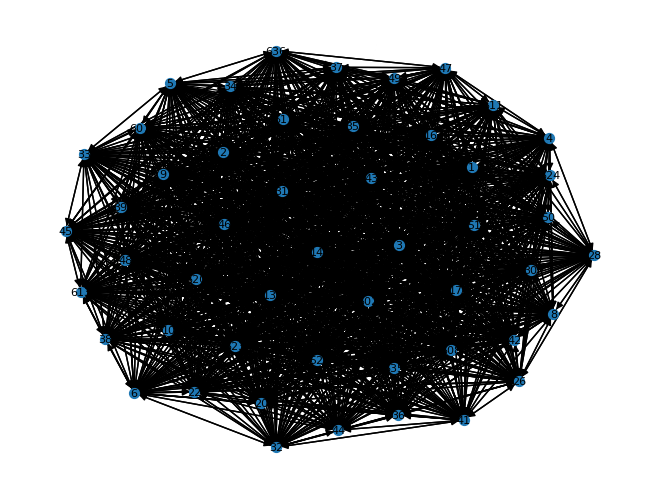

In [55]:
subgraph_nodes = list(G.nodes())[:50]
subgraph = G.subgraph(subgraph_nodes)

nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.show()

In [56]:
aggregated_stations = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_stations:
        aggregated_stations[u] = 0

    for trip in data["trips"]:
        aggregated_stations[u] += trip["ridership"]

top_5_stations = sorted(aggregated_stations.items(), key=lambda x: x[1], reverse=True)[
    :5
]

top_5_stations

[(611, 772832.8064999951),
 (610, 578428.9966000087),
 (607, 421029.6783999983),
 (602, 382816.6319999976),
 (164, 332532.6990000031)]

In [57]:
aggregated_routes = []

for u, v, data in G.edges(data=True):
    total_ridership = sum(trip["ridership"] for trip in data["trips"])
    aggregated_routes.append((u, v, total_ridership))

top_5_routes = sorted(aggregated_routes, key=lambda x: x[2], reverse=True)[:5]

top_5_routes

[(610, 628, 27816.9111),
 (628, 610, 26933.6357),
 (611, 610, 23610.6667),
 (610, 611, 23032.0468),
 (610, 602, 21768.323)]

In [58]:
# Check
origin_ridership = ridership_df.groupby("Origin Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_origins = origin_ridership.sort_values(ascending=False).head(5)
print(top_5_origins)

Origin Station Complex ID
611    772832.8065
610    578428.9966
607    421029.6784
602    382816.6320
164    332532.6990
Name: Estimated Average Ridership, dtype: float64


In [59]:
destination_ridership = ridership_df.groupby("Destination Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_destinations = destination_ridership.sort_values(ascending=False).head(5)
print(top_5_destinations)

Destination Station Complex ID
611    755731.0109
610    553936.6710
607    427831.4631
602    408713.8706
628    324693.1087
Name: Estimated Average Ridership, dtype: float64


In [60]:
routes_ridership = ridership_df.groupby(
    ["Origin Station Complex ID", "Destination Station Complex ID"]
)["Estimated Average Ridership"].sum()

top_5_routes = routes_ridership.sort_values(ascending=False).head(5)
print(top_5_routes)

Origin Station Complex ID  Destination Station Complex ID
610                        628                               27816.9111
628                        610                               26933.6357
611                        610                               23610.6667
610                        611                               23032.0468
                           602                               21768.3230
Name: Estimated Average Ridership, dtype: float64


1a

In [61]:
for borough in ["M", "Bk", "Q", "Bx", "SI"]:

    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    borough_subgraph = G.subgraph(borough_nodes)

    aggregated_ridership = {}
    for u, v, data in borough_subgraph.edges(data=True):

        if u not in aggregated_ridership:

            aggregated_ridership[u] = 0

        for trip in data["trips"]:

            aggregated_ridership[u] += trip["ridership"]

    top_5_origins = sorted(
        aggregated_ridership.items(), key=lambda x: x[1], reverse=True
    )[:5]

    print(f"{borough}: {top_5_origins}")

M: [(611, 492022.89099999913), (610, 375744.056100002), (607, 223684.46730000057), (164, 219993.4277999995), (318, 212053.69609999945)]
Bk: [(617, 101892.60109999987), (636, 55409.06489999984), (620, 44169.229199999856), (51, 39286.06430000029), (345, 38693.42919999978)]
Q: [(447, 115028.43759999995), (616, 106116.53660000024), (450, 49340.885699999926), (451, 47856.67200000009), (279, 42665.570400000215)]
Bx: [(604, 20482.494199999943), (434, 18945.420700000046), (371, 13748.588000000156), (366, 13551.495300000042), (382, 12690.52100000005)]
SI: []


1b

In [62]:
aggregated_ridership = {}
for u, v, data in G.edges(data=True):

    if u not in aggregated_ridership:

        aggregated_ridership[u] = 0

    for trip in data["trips"]:

        if trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday"]:

            aggregated_ridership[u] += trip["ridership"]


top_5_origins_mtw = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]



top_5_origins_mtw

[(611, 366682.6977999996),
 (610, 299994.9464000017),
 (607, 198093.2732000026),
 (602, 178115.10260000048),
 (628, 158768.42939999944)]

1c

In [63]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):

    if u not in aggregated_ridership:

        aggregated_ridership[u] = 0

    for trip in data["trips"]:

        if trip["day_of_week"] in ["Saturday", "Sunday"]:

            aggregated_ridership[u] += trip["ridership"]


top_5_origins_ss = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]



top_5_origins_ss

[(611, 151484.71489999993),
 (607, 81496.3893000002),
 (610, 78418.81549999978),
 (602, 77392.21219999992),
 (164, 69408.95950000006)]

1d

In [64]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0
    for trip in data["trips"]:
        if 1 <= trip["hour_of_day"] <= 5:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_night = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_night

[(611, 23851.845899999837),
 (616, 14400.297700000001),
 (447, 11501.979899999966),
 (450, 11346.55689999999),
 (278, 8971.765100000013)]

In [65]:
# Check
filtered_df = ridership_df[
    (ridership_df["Hour of Day"] >= 1) & (ridership_df["Hour of Day"] <= 5)
]

origin_ridership = filtered_df.groupby("Origin Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_origins_df = origin_ridership.sort_values(ascending=False).head(5)

top_5_origins_df

Origin Station Complex ID
611    23851.8459
616    14400.2977
447    11501.9799
450    11346.5569
278     8971.7651
Name: Estimated Average Ridership, dtype: float64

1e

In [66]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0
    for trip in data["trips"]:
        if 6 <= trip["hour_of_day"] <= 9:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_morning = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

print(top_5_origins_morning)

[(611, 173476.38119999933), (610, 120589.19049999968), (616, 89547.93639999963), (318, 86708.27519999936), (447, 84534.1125000009)]


2a

In [67]:
for borough in ["M", "Bk", "Q", "Bx", "SI"]:
    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    aggregated_ridership = {}

    for u, v, data in G.edges(data=True):
        if v in borough_nodes:
            if v not in aggregated_ridership:
                aggregated_ridership[v] = 0
            for trip in data["trips"]:
                aggregated_ridership[v] += trip["ridership"]

    top_5_destinations = sorted(
        aggregated_ridership.items(), key=lambda x: x[1], reverse=True
    )[:5]

    print(f"{borough}: {top_5_destinations}")

M: [(611, 755731.0109000076), (610, 553936.6709999953), (607, 427831.4630999997), (602, 408713.8705999979), (628, 324693.1086999991)]
Bk: [(617, 182108.8650999996), (120, 155106.0882000009), (636, 142927.4382999992), (620, 117848.19650000075), (345, 86573.23950000125)]
Q: [(616, 273041.5918999972), (447, 238424.81610000014), (606, 113193.42130000012), (450, 109201.55239999967), (451, 103706.43460000036)]
Bx: [(604, 72982.02390000041), (434, 58186.86289999997), (366, 51492.97849999995), (603, 34738.47289999991), (382, 33780.46409999978)]
SI: []


2b

In [68]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if trip["day_of_week"] in ["Thursday", "Friday"]:
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_th_fri = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

print(top_5_destinations_th_fri)

[(611, 254027.9514999997), (610, 193929.8707), (607, 146122.45520000084), (602, 137625.25149999914), (628, 112550.08569999952)]


2c

In [69]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if trip["day_of_week"] == "Saturday":
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_saturday = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

print(top_5_destinations_saturday)

[(611, 82215.39059999987), (607, 48560.38809999996), (602, 48271.31670000008), (610, 40886.469899999924), (164, 35605.25350000009)]


2d

In [70]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if 0 <= trip["hour_of_day"] <= 5:
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_night = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

print(top_5_destinations_night)

[(611, 24700.964199999948), (610, 19211.66700000001), (607, 13386.72769999996), (616, 12220.43559999997), (628, 12128.324100000027)]


2e

In [71]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if 18 <= trip["hour_of_day"] <= 21:
            aggregated_ridership[v] += trip["ridership"]
top_5_destinations_evening = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

print(top_5_destinations_evening)

[(611, 130974.97279999986), (610, 67513.95080000036), (607, 63408.88060000024), (616, 62489.09310000007), (602, 60015.50270000017)]


3a

In [72]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if (u, v) not in aggregated_ridership:
        aggregated_ridership[(u, v)] = 0
    for trip in data["trips"]:
        if trip["day_of_week"] == "Monday" and 13 <= trip["hour_of_day"] <= 14:
            aggregated_ridership[(u, v)] += trip["ridership"]

top_10_pairs_monday = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_pairs_monday)

[((610, 611), 282.2022), ((447, 450), 273.77160000000003), ((628, 610), 272.3798), ((447, 451), 271.3252), ((610, 602), 270.66179999999997), ((447, 616), 259.85699999999997), ((602, 610), 255.8078), ((451, 447), 239.9478), ((611, 610), 232.1258), ((610, 628), 231.0762)]


3b

In [73]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    source_borough = G.nodes[u]["borough"]
    if (u, v) not in aggregated_ridership and source_borough == "Q":
        aggregated_ridership[(u, v)] = 0
    for trip in data["trips"]:
        if (
            source_borough == "Q"
            and trip["day_of_week"] == "Friday"
            and 18 <= trip["hour_of_day"] <= 21
        ):
            aggregated_ridership[(u, v)] += trip["ridership"]

top_10_pairs_queens_friday = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_pairs_queens_friday)

[((447, 616), 645.8218), ((447, 450), 644.121), ((447, 451), 593.8203), ((451, 447), 433.6342), ((447, 452), 385.55960000000005), ((616, 447), 345.3137), ((616, 611), 290.4628), ((450, 447), 278.0807), ((447, 449), 240.2326), ((453, 447), 235.28950000000003)]


3c

In [74]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    source_borough = G.nodes[u]["borough"]
    if (u, v) not in aggregated_ridership and source_borough == "Bk":
        aggregated_ridership[(u, v)] = 0
    for trip in data["trips"]:
        if source_borough == "Bk" and 1 <= trip["hour_of_day"] <= 5:
            aggregated_ridership[(u, v)] += trip["ridership"]

top_10_pairs_brooklyn_night = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_pairs_brooklyn_night)

[((345, 610), 324.15459999999996), ((359, 611), 213.30200000000002), ((359, 610), 178.55929999999998), ((345, 602), 176.2855), ((345, 628), 169.7879), ((345, 611), 165.3638), ((120, 119), 161.08069999999995), ((359, 628), 152.14210000000003), ((359, 318), 145.7379), ((345, 414), 142.221)]


3d

In [75]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if G.nodes[u]["borough"] == "Bk" and G.nodes[v]["borough"] == "M":
        if (u, v) not in aggregated_ridership:
            aggregated_ridership[(u, v)] = 0

        for trip in data["trips"]:
            if (
                trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]
                and 6 <= trip["hour_of_day"] <= 7
            ):
                aggregated_ridership[(u, v)] += trip["ridership"]

top_10_brooklyn_manhattan = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_brooklyn_manhattan)

[((617, 414), 1029.6122999999998), ((345, 610), 692.6152000000001), ((51, 607), 655.3457000000001), ((620, 610), 653.3663), ((359, 610), 589.2357), ((345, 628), 580.2716), ((359, 628), 557.0980999999999), ((120, 610), 555.5914), ((51, 225), 503.5513), ((54, 225), 478.5522)]


3e

In [76]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if G.nodes[u]["borough"] == "Bx" and G.nodes[v]["borough"] == "M":
        if (u, v) not in aggregated_ridership:
            aggregated_ridership[(u, v)] = 0

        for trip in data["trips"]:
            if (
                trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]
                and 6 <= trip["hour_of_day"] <= 7
            ):
                aggregated_ridership[(u, v)] += trip["ridership"]

top_10_bronx_manhattan = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_bronx_manhattan)

[((366, 610), 562.2564), ((366, 602), 402.36749999999995), ((366, 392), 395.6825), ((366, 399), 383.7979), ((366, 397), 372.9343), ((366, 612), 357.86589999999995), ((366, 628), 346.6705), ((366, 622), 320.3933), ((604, 614), 306.00469999999996), ((378, 397), 302.63100000000003)]


3f

In [77]:
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if G.nodes[u]["borough"] == "SI" and G.nodes[v]["borough"] == "M":
        if (u, v) not in aggregated_ridership:
            aggregated_ridership[(u, v)] = 0

        for trip in data["trips"]:
            if (
                trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]
                and 6 <= trip["hour_of_day"] <= 7
            ):
                aggregated_ridership[(u, v)] += trip["ridership"]

top_10_statenisland_manhattan = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

print(top_10_statenisland_manhattan)

[]


Confirming that staten island does not appear in ridership_df

In [78]:
staten_island_origin_count = 0
staten_island_destination_count = 0

for u, v, data in G.edges(data=True):
    source_borough = G.nodes[u]["borough"]
    destination_borough = G.nodes[v]["borough"]

    if source_borough == "SI":
        for trip in data["trips"]:
            staten_island_origin_count += 1

    if destination_borough == "SI":
        for trip in data["trips"]:
            staten_island_destination_count += 1

print(staten_island_origin_count)
print(staten_island_destination_count)

0
0


In [79]:
staten_island_station_ids = stations_df[stations_df["Borough"] == "SI"][
    "Complex ID"
].unique()

staten_island_origin_df = ridership_df[
    ridership_df["Origin Station Complex ID"].isin(staten_island_station_ids)
]

staten_island_destination_df = ridership_df[
    ridership_df["Destination Station Complex ID"].isin(staten_island_station_ids)
]

print(len(staten_island_origin_df))
print(len(staten_island_destination_df))

0
0


In [80]:
unique_boroughs = stations_df["Borough"].unique()

print(unique_boroughs)

['Q' 'M' 'Bk' 'Bx' 'SI']


In [81]:
staten_island_station_ids = stations_df[stations_df["Borough"] == "SI"][
    "Complex ID"
].unique()
staten_island_station_ids

array([501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
       514, 515, 516, 517, 518, 519, 522, 523], dtype=int64)

In [82]:
staten_island_origin_df = ridership_df[
    ridership_df["Origin Station Complex ID"].isin(staten_island_station_ids)
]
staten_island_destination_df = ridership_df[
    ridership_df["Destination Station Complex ID"].isin(staten_island_station_ids)
]

print(len(staten_island_origin_df))
print(len(staten_island_destination_df))

0
0
